<div style="background-color:antiquewhite; padding:10px">
<h1 style="text-align:center;color:Maroon">ML Project Phase 2</h1>
<h2 style="text-align:center;color:green">Done By : Manas P P</h2>
</div>

<div style = "background-color:Ghostwhite; padding:7px;">
<h1 style="text-align:center;">GPU runtime prediction of matrix multiplication of  two 2048*2048 matrices on a SGEMM GPU.</h1>
</div>

---

<h2 style = "color:blue">Problem Statement</h2>

The runtime of a matrix multiplication operation between two 2048 by 2048 matrices performed on a parameterizable SGEMM GPU kernel is dependent on the parameter combination employed. The task is to predict the runtime provided a combination of the 14 possible parameters.  

---

<h2 style = "color:blue">Datasets used for the problem </h2>

We used the SGEMM GPU kernel performance Data Set ([dataset](https://archive.ics.uci.edu/ml/datasets/SGEMM+GPU+kernel+performance)) availbale on UCI ML Repository. The dataset contains the runtimes of 4 independent runs with each parameter combination. I work with the first Run (i.e, the target variable Run1). 
<br>
<p>There are 14 parameters, the first 10 are ordinal and can only take up to 
4 different powers of two values, and the 4 last variables are binary. All times are measured in milliseconds. The experiment was run on a desktop workstation running Ubuntu 16.04 Linux
with an Intel Core i5 (3.5GHz), 16GB RAM, and a NVidia Geforce GTX 680 4GB 
GF580 GTX-1.5GB GPU. Out of 1327104 total parameter combinations, only 261400 are feasible 
(due to various kernel constraints). </p>

<h4>Attribute Information:</h4>

<ul>Independent variables:
<li>1-2. MWG, NWG: per-matrix 2D tiling at workgroup level: {16, 32, 64, 128} (integer)</li>
<li>3. KWG: inner dimension of 2D tiling at workgroup level: {16, 32} (integer)</li>
<li>4-5. MDIMC, NDIMC: local workgroup size: {8, 16, 32} (integer)</li>
<li>6-7. MDIMA, NDIMB: local memory shape: {8, 16, 32} (integer)</li>
<li>8. KWI: kernel loop unrolling factor: {2, 8} (integer)</li>
<li>9-10. VWM, VWN: per-matrix vector widths for loading and storing: {1, 2, 4, 8} (integer)</li>
<li>11-12. STRM, STRN: enable stride for accessing off-chip memory within a single thread: {0, 1} (categorical)</li>
<li>13-14. SA, SB: per-matrix manual caching of the 2D workgroup tile: {0, 1} (categorical)</li>
</ul>
<ul>Output:
<li>15-18. Run1, Run2, Run3, Run4: performance times in milliseconds for 4 independent runs using the same parameters. They range between 13.25 and 3397.08</li>
</ul>

<h5>Citation Request:</h5>

<ul>
    
<li>Rafael Ballester-Ripoll, Enrique G. Paredes, Renato Pajarola.
Sobol Tensor Trains for Global Sensitivity Analysis.
In arXiv Computer Science / Numerical Analysis e-prints, 2017.
</li>
<li>Cedric Nugteren and Valeriu Codreanu.
CLTune: A Generic Auto-Tuner for OpenCL Kernels.
In: MCSoC: 9th International Symposium on Embedded Multicore/Many-core Systems-on-Chip. IEEE, 2015
</li>
</ul>

---

<h2 style = "color:blue">Python Pacakages used in this work</h2>

<ul>
    <li>NumPy : One of the most popular libraries for array computation in python, we use this to deal with vectors and matrices. </li>
    <li>Pandas : A popular data analysis and manipulation tool, this is used organise the data and deal with it in a tabular format. </li>
    <li>Matplotlib : It is a plotting library for Python and we use it make most of the plots in this work.</li>
    <li>Scikit-Learn : Built on NumPy, SciPy and matplotlib, we use the provided APIs to preprocess data, train machine learning models and make predictions.</li>
    <li>Seaborn : Built on matplotlib, it provides a high level interface for plotting graphs and is used in some of the plots.</li>
</ul>

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib
import seaborn as sns

print("Sklearn version: ",sklearn.__version__)
print("Pandas version: ",pd.__version__)
print("Numpy version: ",np.__version__)
print("Matplotlib version: ",matplotlib.__version__)
print("Seabron version: ",sns.__version__)

Sklearn version:  0.24.1
Pandas version:  1.2.4
Numpy version:  1.19.5
Matplotlib version:  3.3.4
Seabron version:  0.11.1


<h2 style = "color:blue">Data Preprocessing and EDA</h2>

1) There are 10 ordinal variables which we process using sklearn's 
[OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)

2) There are 4 categorical variables(nominal) which we process using pandas's
[get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)

In [2]:
data = pd.read_csv("sgemm_product_dataset\sgemm_product.csv")

from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
tr = encoder.fit_transform(data[['MWG', 'NWG', 'KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB', 'KWI', 'VWM','VWN']])
data[['MWG', 'NWG', 'KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB', 'KWI', 'VWM','VWN']] = tr

data = pd.get_dummies(data,columns = ['STRM', 'STRN', 'SA', 'SB'],drop_first  = True)

data = data[['MWG', 'NWG', 'KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB', 'KWI', 'VWM','VWN', 'STRM_1',
             'STRN_1', 'SA_1', 'SB_1', 'Run1 (ms)']]

In [3]:
print(" ")
print("-------------------------------------------------------------------")
print("Columns and the datatypes in the dataframe : ")
print()
print(list(zip(list(data.columns),list(data.dtypes))))
print("-------------------------------------------------------------------")
print("Shape of the dataframe : ",data.shape)
print(" ")
print("-------------------------------------------------------------------")

 
-------------------------------------------------------------------
Columns and the datatypes in the dataframe : 

[('MWG', dtype('float64')), ('NWG', dtype('float64')), ('KWG', dtype('float64')), ('MDIMC', dtype('float64')), ('NDIMC', dtype('float64')), ('MDIMA', dtype('float64')), ('NDIMB', dtype('float64')), ('KWI', dtype('float64')), ('VWM', dtype('float64')), ('VWN', dtype('float64')), ('STRM_1', dtype('uint8')), ('STRN_1', dtype('uint8')), ('SA_1', dtype('uint8')), ('SB_1', dtype('uint8')), ('Run1 (ms)', dtype('float64'))]
-------------------------------------------------------------------
Shape of the dataframe :  (241600, 15)
 
-------------------------------------------------------------------


In [4]:
data.describe()[['MWG', 'NWG', 'KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB', 'KWI', 'VWM']]

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM
count,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000
mean,2.060662,2.060662,0.594570,0.612450,0.612450,0.908344,0.908344,0.500000,0.939338
std,0.958493,0.958493,0.490976,0.704578,0.704578,0.780609,0.780609,0.500001,0.958493
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000
75%,3.000000,3.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000
max,3.000000,3.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000


In [5]:
data.describe()[['VWN', 'STRM_1', 'STRN_1', 'SA_1', 'SB_1', 'Run1 (ms)']]

,VWN,STRM_1,STRN_1,SA_1,SB_1,Run1 (ms)
count,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000
mean,0.939338,0.500000,0.500000,0.500000,0.500000,217.647852
std,0.958493,0.500001,0.500001,0.500001,0.500001,369.012422
min,0.000000,0.000000,0.000000,0.000000,0.000000,13.290000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,40.660000
50%,1.000000,0.500000,0.500000,0.500000,0.500000,69.825000
75%,2.000000,1.000000,1.000000,1.000000,1.000000,228.530000
max,3.000000,1.000000,1.000000,1.000000,1.000000,3339.630000


### Checking for outliers

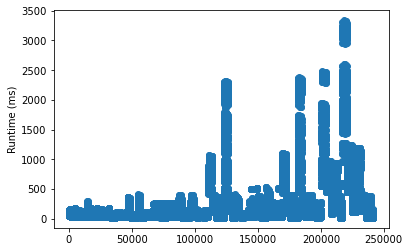

In [6]:
import matplotlib.pyplot as plt

fig1,ax1 = plt.subplots()
ax1.scatter([i for i in range(data.shape[0])],data['Run1 (ms)'])
ax1.set_ylabel("Runtime (ms)")
plt.show()

<ul>
<li>It doesn't seem like there are any clear outliers, the higher run times could be because of poor parameter combination.
</li>
</ul>

### Plotting the correlation between variables

<AxesSubplot:>

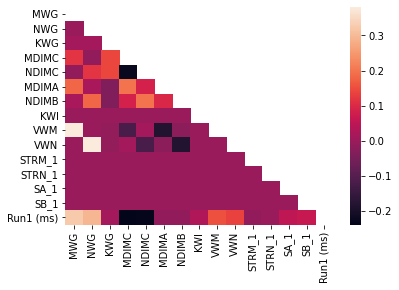

In [7]:
cor_mat = data.corr()
mask = np.triu(np.ones_like(cor_mat, dtype=bool))
sns.heatmap(cor_mat, mask=mask)

<ul>
    <li> There isn't much correlation between the independent variables or between the independent and target variables.</li>
</ul>

### Observing the plots between the target and independent varaibles

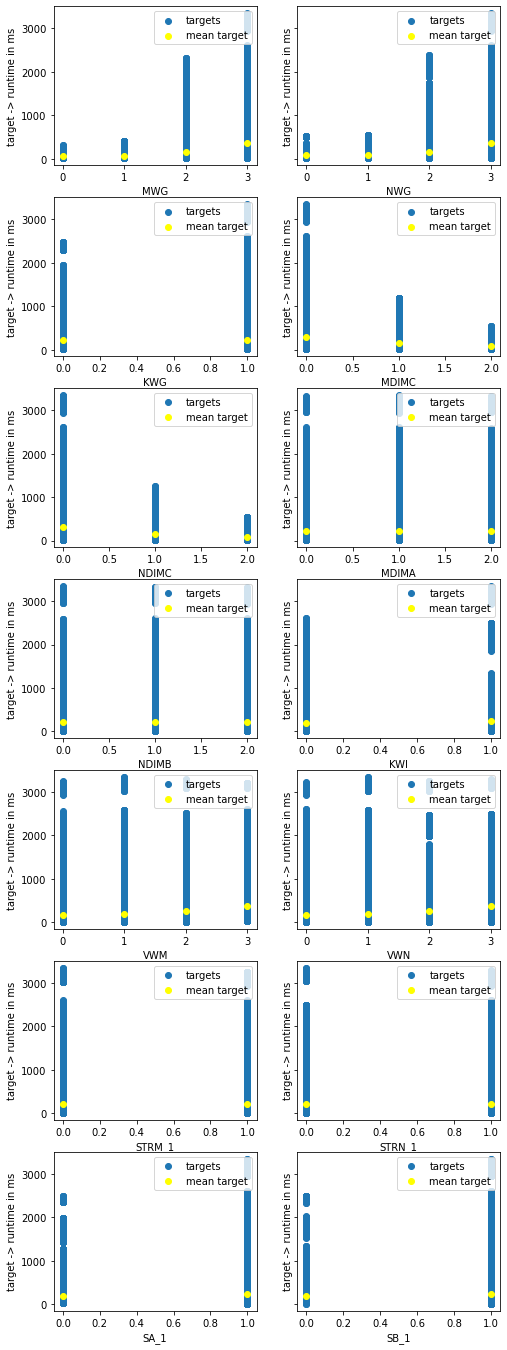

In [39]:
fig2,ax2 = plt.subplots(7,2,figsize = (8,24),sharey = True)
cols = data.columns
count = 0
for i in range(0,7):
    for j in range(0,2):
        ax2[i,j].scatter(data[cols[count]],data['Run1 (ms)'])
        vals = data[cols[count]].unique()
        targ = [np.mean(data[data[cols[count]] == i]['Run1 (ms)']) for i in vals]
        ax2[i,j].scatter(vals,targ,color = 'yellow')
        ax2[i,j].set_ylabel('target -> runtime in ms')
        ax2[i,j].set_xlabel(f'{cols[count]}')
        ax2[i,j].legend(['targets', 'mean target'],loc = 1)
        count += 1

The correlation plot showed that there isn't much correlation between the target and independent variables. However looking at the graph above we can see that some variables are showing an upper limit on the possible target values, these variables include **NDIMC**, **NWG**, **MDIMC**, **MWG**, **SA_1**,**SB_1**, **KWG** and **KWI**. We expect these variables to be of greater importance in our models.

<h2 style = "color:blue">Training the models and performing inference</h2>

<ul>Algorithm used for the problem.
    <li>Linear Regression: We start with this basic regression algorithm.</li>
    <li>Support Vector Regression</li>
    <li>Decision Tree Regression: We observed that some variables have an upper bound on the target variable that the job assumes and this algorithm could exploit that in its tree structure.</li>
</ul>

### Train Test Split

In [8]:
X = data[['MWG', 'NWG', 'KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB', 'KWI', 'VWM','VWN', 'STRM_1',
             'STRN_1', 'SA_1', 'SB_1']]
Y = data[['Run1 (ms)']]

from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.15)

In [9]:
from sklearn.metrics import mean_squared_error, make_scorer
mse = make_scorer(mean_squared_error)

### Calculating the Cross validation Scores on each algorithm

We perform 5 fold cross validation on each of the algorithm and calculate the RMSE (root mean squared error) as the performance evaluation metric.

### Self implementing the Linear Regression algorithm

In [16]:
from sklearn.preprocessing import MinMaxScaler
def gradient_descent_mv(alpha, x, y, max_iter=1000):
    x,val_x,y,val_y = train_test_split(x,y)
    
    x = np.append(x,np.reshape(np.array([1]*x.shape[0]),(x.shape[0],1)),axis = 1)
    val_x = np.append(val_x,np.reshape(np.array([1]*val_x.shape[0]),(val_x.shape[0],1)),axis = 1)
    theta = [0]*x.shape[1]
    theta =  np.reshape(theta,(len(theta),1))
    mse = np.sum(np.square(np.dot(val_x,theta) - np.array(val_y)))/(val_x.shape[0])
    min_mse = mse
    count = 0
    temp = []
    for i in range(0,max_iter):
        theta = np.reshape(theta,(len(theta),1)) - (alpha*(np.dot(np.transpose(x),(np.reshape(np.dot(x,theta),(x.shape[0],1)) - np.array(y))))/(x.shape[1]))
        temp_mse = np.sum(np.square(np.dot(val_x,theta) - val_y))/(val_x.shape[0])
        if (temp_mse['Run1 (ms)'] > mse):
            temp.append(theta)
            count += 1
            if (count > 100):
                theta = temp[0]
                break
        else:
            if (temp_mse['Run1 (ms)'] <= min_mse):
                mse = temp_mse['Run1 (ms)']
                min_mse = temp_mse['Run1 (ms)']
                temp = []
                count = 0
            else:
                temp.append(theta)
    return theta

In [17]:
from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
theta_l = []
self_lr_cv = []
print("The 5 fold cross validation scores: ")
for train_index, val_index in ss.split(X_train):
    x_train = X_train.iloc[train_index]
    y_train = Y_train.iloc[train_index]
    val_x = X_train.iloc[val_index]
    val_y = Y_train.iloc[val_index]
    theta = gradient_descent_mv(0.0001, x_train, y_train)
    theta_l.append(theta)
    pred_y = []
    for i in range(val_x.shape[0]):
        temp_l = list(np.array(val_x.iloc[i,:]))
        temp_l.append(1)
        pred_y.append(np.dot(np.array(temp_l),theta))
    self_lr_cv.append(np.sqrt(mean_squared_error(pred_y,val_y)))
    print(np.sqrt(mean_squared_error(pred_y,val_y)))

The 5 fold cross validation scores: 
2789.4497641742414
2802.9345625502156
2800.6877356400933
2806.7056628538808
2802.418200242353


In [18]:
print("Prediction score on unseen test data: ")
final_pred = []
for theta in theta_l:   
    pred_y = []
    for i in range(X_test.shape[0]):
        temp_l = list(np.array(X_test.iloc[i,:]))
        temp_l.append(1)
        pred_y.append(np.dot(np.array(temp_l),theta))
        final_pred.append(pred_y)
final_y = (np.array(final_pred[0]) + np.array(final_pred[1]) + np.array(final_pred[2]) + 
                                                    np.array(final_pred[3]) + np.array(final_pred[4]))/5
self_lr_ts = np.sqrt(mean_squared_error(final_y,Y_test))
print(np.sqrt(mean_squared_error(final_y,Y_test)))

Prediction score on unseen test data: 
2799.524655195195


### Sklearn's Linear Regression 

In [19]:
from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
from sklearn.linear_model import LinearRegression
sklearn_lr = []
lr_cv = []
print("The 5 fold cross validation scores: ")
for train_index, val_index in ss.split(X_train):
    x_train = X_train.iloc[train_index]
    y_train = Y_train.iloc[train_index]
    val_x = X_train.iloc[val_index]
    val_y = Y_train.iloc[val_index]
    sklearn_lr.append(LinearRegression().fit(x_train,y_train))
    pred_y = sklearn_lr[-1].predict(val_x)
    lr_cv.append(np.sqrt(mean_squared_error(pred_y,val_y)))
    print(np.sqrt(mean_squared_error(pred_y,val_y)))

The 5 fold cross validation scores: 
287.62208672138576
283.08917087038225
281.4785986143169
283.2490541561185
284.09931582958245


In [20]:
print("Prediction score on unseen test data: ")
final_pred = []
for lr in sklearn_lr:   
        final_pred.append(lr.predict(X_test))
final_y = (np.array(final_pred[0]) + np.array(final_pred[1]) + np.array(final_pred[2]) + 
                                                    np.array(final_pred[3]) + np.array(final_pred[4]))/5
lr_ts = np.sqrt(mean_squared_error(final_y,Y_test))
print(np.sqrt(mean_squared_error(final_y,Y_test)))

Prediction score on unseen test data: 
283.48846479209516


### Support Vector Regression

In [21]:
from sklearn.svm import LinearSVR
from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
sklearn_sv = []
sv_cv = []
print("The 5 fold cross validation scores: ")
for train_index, val_index in ss.split(X_train):
    x_train = X_train.iloc[train_index]
    y_train = Y_train.iloc[train_index]
    val_x = X_train.iloc[val_index]
    val_y = Y_train.iloc[val_index]
    sklearn_sv.append(LinearSVR().fit(x_train,np.array(y_train).ravel()))
    pred_y = sklearn_sv[-1].predict(val_x)
    sv_cv.append(np.sqrt(mean_squared_error(pred_y,val_y)))
    print(np.sqrt(mean_squared_error(pred_y,val_y)))

The 5 fold cross validation scores: 
330.8258068394832
325.6886826126811
322.4208018505334
324.8332560719293
326.27986367224855


In [22]:
print("Prediction score on unseen test data: ")
final_pred = []
for sv in sklearn_sv:   
        final_pred.append(sv.predict(X_test))
final_y = (np.array(final_pred[0]) + np.array(final_pred[1]) + np.array(final_pred[2]) + 
                                                    np.array(final_pred[3]) + np.array(final_pred[4]))/5
sv_ts = np.sqrt(mean_squared_error(final_y,Y_test))
print(np.sqrt(mean_squared_error(final_y,Y_test)))

Prediction score on unseen test data: 
326.2417608682769


### Decision Tree Regression

In [13]:
from sklearn.tree import DecisionTreeRegressor
sklearn_dt = []
dt_cv = []
print("The 5 fold cross validation scores: ")
for train_index, val_index in ss.split(X_train):
    x_train = X_train.iloc[train_index]
    y_train = Y_train.iloc[train_index]
    val_x = X_train.iloc[val_index]
    val_y = Y_train.iloc[val_index]
    sklearn_dt.append(DecisionTreeRegressor().fit(x_train,y_train))
    pred_y = sklearn_dt[-1].predict(val_x)
    dt_cv.append(np.sqrt(mean_squared_error(pred_y,val_y)))
    print(np.sqrt(mean_squared_error(pred_y,val_y)))

The 5 fold cross validation scores: 
5.754871360400381
6.008357752235373
5.600425090647011
5.607841512879983
5.917259280599842


In [14]:
print("Prediction score on unseen test data: ")
final_pred = []
for dt in sklearn_dt:   
        final_pred.append(dt.predict(X_test))
final_y = (np.array(final_pred[0]) + np.array(final_pred[1]) + np.array(final_pred[2]) + 
                                                    np.array(final_pred[3]) + np.array(final_pred[4]))/5
dt_ts = np.sqrt(mean_squared_error(final_y,Y_test))
print(np.sqrt(mean_squared_error(final_y,Y_test)))

Prediction score on unseen test data: 
4.642695699822237


<p>Using the feature_importance attribute of Decision Tree Regressor we observe the importance of the independent variables in the model.</p>

In [15]:
feature_imp = []
feature_imp_mean = sklearn_dt[0].feature_importances_
for i in range(1,4):
    feature_imp_mean += np.array(sklearn_dt[0].feature_importances_)
feature_imp_mean = np.array(feature_imp_mean)/5
for i in range(14):
    feature_imp.append((X.columns[i],feature_imp_mean[i]))
feature_imp = sorted(list(feature_imp),key = lambda x: x[1])
feature_imp.reverse()
feature_imp

[('NDIMC', 0.1842862193799159),
 ('NWG', 0.1473463356126496),
 ('MDIMC', 0.131881683377357),
 ('MWG', 0.1304506031097396),
 ('SA_1', 0.06266432864981204),
 ('SB_1', 0.060596384290234596),
 ('KWG', 0.049662159654230785),
 ('KWI', 0.026320018780262567),
 ('VWN', 0.0026204805453951333),
 ('VWM', 0.00250666863384419),
 ('STRM_1', 0.0008898498999369284),
 ('STRN_1', 0.000647882340474043),
 ('MDIMA', 6.83751050273648e-05),
 ('NDIMB', 5.901062112014638e-05)]

## Dimensionality Reduction

We use PCA to reduce the dimension of X. We see that reducing the dimensions is not effective. We need at least 11 dimensions to capture 0.9% of the explained variance. Infact, the decision tree regressor clearly losses its effectiveness in the reduced dimension space.

In [23]:
from sklearn.decomposition import PCA
pca = PCA(11)
pca.fit(X)
sum(pca.explained_variance_ratio_)

0.9055907704789264

In [24]:
X_trainr,X_testr,Y_trainr,Y_testr = train_test_split(pca.transform(X),Y)
X_trainr = pd.DataFrame(X_trainr)
X_testr = pd.DataFrame(X_testr)

In [25]:
from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
theta_lr = []
self_lrr_cv = []
print("The 5 fold cross validation scores for dimension reduced: ")
for train_index, val_index in ss.split(X_trainr):
    x_train = X_trainr.iloc[train_index]
    y_train = Y_trainr.iloc[train_index]
    val_x = X_trainr.iloc[val_index]
    val_y = Y_trainr.iloc[val_index]
    theta = gradient_descent_mv(0.0001, x_train, y_train)
    theta_lr.append(theta)
    pred_y = []
    for i in range(val_x.shape[0]):
        temp_l = list(np.array(val_x.iloc[i,:]))
        temp_l.append(1)
        pred_y.append(np.dot(np.array(temp_l),theta))
    self_lrr_cv.append(np.sqrt(mean_squared_error(pred_y,val_y)))
    print(np.sqrt(mean_squared_error(pred_y,val_y)))

The 5 fold cross validation scores for dimension reduced: 
304.10211246682593
300.813881350857
298.04538228469335
301.238190781458
296.2571832264385


In [26]:
print("Prediction score on unseen test data: ")
final_pred = []
for theta in theta_lr:   
    pred_y = []
    for i in range(X_testr.shape[0]):
        temp_l = list(np.array(X_testr.iloc[i,:]))
        temp_l.append(1)
        pred_y.append(np.dot(np.array(temp_l),theta))
        final_pred.append(pred_y)
final_y = (np.array(final_pred[0]) + np.array(final_pred[1]) + np.array(final_pred[2]) + 
                                                    np.array(final_pred[3]) + np.array(final_pred[4]))/5
self_lrr_ts = np.sqrt(mean_squared_error(final_y,Y_testr))
print(np.sqrt(mean_squared_error(final_y,Y_testr)))

Prediction score on unseen test data: 
300.7551220798212


In [27]:
from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
from sklearn.linear_model import LinearRegression
sklearn_lrr = []
lrr_cv = []
print("The 5 fold cross validation scores for dimension reduced: ")
for train_index, val_index in ss.split(X_trainr):
    x_train = X_trainr.iloc[train_index]
    y_train = Y_trainr.iloc[train_index]
    val_x = X_trainr.iloc[val_index]
    val_y = Y_trainr.iloc[val_index]
    sklearn_lrr.append(LinearRegression().fit(x_train,y_train))
    pred_y = sklearn_lrr[-1].predict(val_x)
    lrr_cv.append(np.sqrt(mean_squared_error(pred_y,val_y)))
    print(np.sqrt(mean_squared_error(pred_y,val_y)))

The 5 fold cross validation scores for dimension reduced: 
304.09658484760445
300.8070699844939
298.029956166867
301.22946431082886
296.258103915261


In [28]:
print("Prediction score on unseen test data: ")
final_pred = []
for lrr in sklearn_lrr:   
        final_pred.append(lrr.predict(X_testr))
final_y = (np.array(final_pred[0]) + np.array(final_pred[1]) + np.array(final_pred[2]) + 
                                                    np.array(final_pred[3]) + np.array(final_pred[4]))/5
lrr_ts = np.sqrt(mean_squared_error(final_y,Y_testr))
print(np.sqrt(mean_squared_error(final_y,Y_testr)))

Prediction score on unseen test data: 
300.7420937307404


In [29]:
from sklearn.svm import LinearSVR
from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
sklearn_svr = []
svr_cv = []
print("The 5 fold cross validation scores for dimension reduced: ")
for train_index, val_index in ss.split(X_trainr):
    x_train = X_trainr.iloc[train_index]
    y_train = Y_trainr.iloc[train_index]
    val_x = X_trainr.iloc[val_index]
    val_y = Y_trainr.iloc[val_index]
    sklearn_svr.append(LinearSVR().fit(x_train,np.array(y_train).ravel()))
    pred_y = sklearn_svr[-1].predict(val_x)
    svr_cv.append(np.sqrt(mean_squared_error(pred_y,val_y)))
    print(np.sqrt(mean_squared_error(pred_y,val_y)))

The 5 fold cross validation scores for dimension reduced: 
334.2087625229217
330.36172657187075
327.8532989270862
330.8486622011799
324.259263617484


In [30]:
print("Prediction score on unseen test data: ")
final_pred = []
for svr in sklearn_svr:   
        final_pred.append(svr.predict(X_testr))
final_y = (np.array(final_pred[0]) + np.array(final_pred[1]) + np.array(final_pred[2]) + 
                                                    np.array(final_pred[3]) + np.array(final_pred[4]))/5
svr_ts = np.sqrt(mean_squared_error(final_y,Y_testr))
print(np.sqrt(mean_squared_error(final_y,Y_testr)))

Prediction score on unseen test data: 
330.0355582496593


In [31]:
from sklearn.tree import DecisionTreeRegressor
sklearn_dtr = []
dtr_cv = []
print("The 5 fold cross validation scores for dimension reduced: ")
for train_index, val_index in ss.split(X_trainr):
    x_train = X_trainr.iloc[train_index]
    y_train = Y_trainr.iloc[train_index]
    val_x = X_trainr.iloc[val_index]
    val_y = Y_trainr.iloc[val_index]
    sklearn_dtr.append(DecisionTreeRegressor().fit(x_train,y_train))
    pred_y = sklearn_dtr[-1].predict(val_x)
    dtr_cv.append(np.sqrt(mean_squared_error(pred_y,val_y)))
    print(np.sqrt(mean_squared_error(pred_y,val_y)))

The 5 fold cross validation scores for dimension reduced: 
134.80138413143445
135.46803257668012
130.24565148648563
127.63386031659338
128.6479744623993


In [32]:
print("Prediction score on unseen test data: ")
final_pred = []
for dtr in sklearn_dtr:   
        final_pred.append(dtr.predict(X_testr))
final_y = (np.array(final_pred[0]) + np.array(final_pred[1]) + np.array(final_pred[2]) + 
                                                    np.array(final_pred[3]) + np.array(final_pred[4]))/5
dtr_ts = np.sqrt(mean_squared_error(final_y,Y_testr))
print(np.sqrt(mean_squared_error(final_y,Y_testr)))

Prediction score on unseen test data: 
92.25787359594212


### Visualising the results

[]

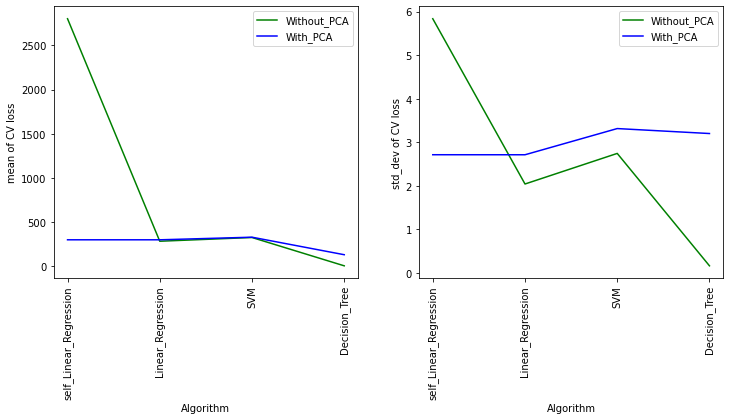

In [33]:
fig,ax = plt.subplots(1,2,figsize = (12,5))
cv_mean = [np.array(self_lr_cv).mean(),np.array(lr_cv).mean(),np.array(sv_cv).mean(),np.array(dt_cv).mean()]
cv_mean_pca = [np.array(self_lrr_cv).mean(),np.array(lrr_cv).mean(),np.array(svr_cv).mean(),np.array(dtr_cv).mean()]
cv_std = [np.array(self_lr_cv).std(),np.array(lr_cv).std(),np.array(sv_cv).std(),np.array(dt_cv).std()]
cv_std_pca = [np.array(self_lrr_cv).std(),np.array(lrr_cv).std(),np.array(svr_cv).std(),np.array(dtr_cv).std()]
x0 = ['self_Linear_Regression','Linear_Regression','SVM','Decision_Tree']

ax[0].plot(x0,cv_mean,color = 'green')
ax[0].plot(x0,cv_mean_pca,color = 'blue')
ax[0].set_ylabel("mean of CV loss")
ax[0].set_xlabel('Algorithm')
ax[0].legend(['Without_PCA','With_PCA'])
ax[0].tick_params(axis = 'x',rotation = 90)

ax[1].plot(x0,cv_std,color = 'green')
ax[1].plot(x0,cv_std_pca,color = 'blue')
ax[1].set_ylabel("std_dev of CV loss")
ax[1].set_xlabel('Algorithm')
ax[1].legend(['Without_PCA','With_PCA'])
ax[1].tick_params(axis = 'x',rotation = 90)
plt.plot()

[]

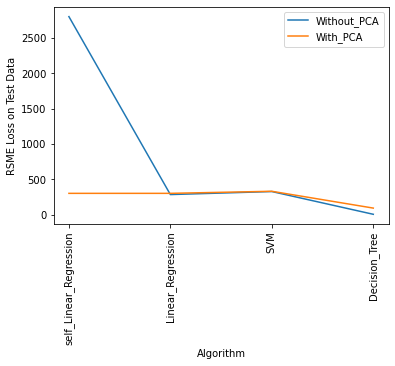

In [34]:
fig,ax = plt.subplots()
ax.plot(x0,[self_lr_ts,lr_ts,sv_ts,dt_ts])
ax.plot(x0,[self_lrr_ts,lrr_ts,svr_ts,dtr_ts])
ax.set_ylabel("RSME Loss on Test Data")
ax.set_xlabel("Algorithm")
ax.legend(['Without_PCA','With_PCA'])
ax.tick_params(axis = 'x',rotation = 90)
plt.plot()

## Conclusions

It was possible to accurately predict the Runtime of the matrix multiplication using the Decision Tree Regressor. The RMSE loss on 36,240 samples was 4.38 ms. We also saw that thee features NDIMC, NWG, MDIMC, MWG, SA_1,SB_1,KWG and KWI where of greater importance to the model than the other features.